In [5]:
import tensorflow as tf

from srcnn.dataset import prepare_input_image, prepare_output_image
from srcnn.plot import plot_predictions, display_psnr

import os
import glob

In [6]:
def get_padding(model):
    sample_size = 100
    sample = tf.zeros([sample_size, sample_size, 3], dtype=tf.float32)
    sample_out_size, _, _ = model.predict(tf.stack([sample]))[0].shape
    return (sample_size - sample_out_size) // 2

,Image Name,PSNR: Input,PSNR: SRCNN
0,baby,30.160,30.250
1,bird,28.285,28.586
2,butterfly,20.716,21.830
3,head,28.525,28.674
4,woman,25.091,25.510


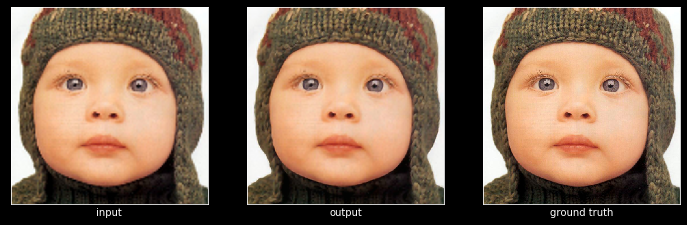

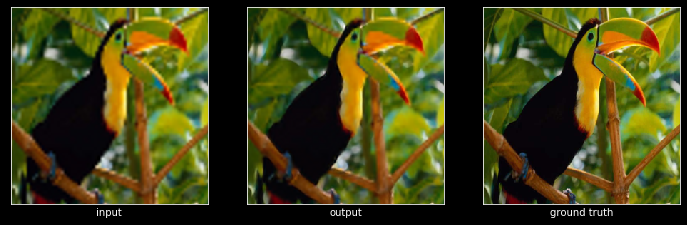

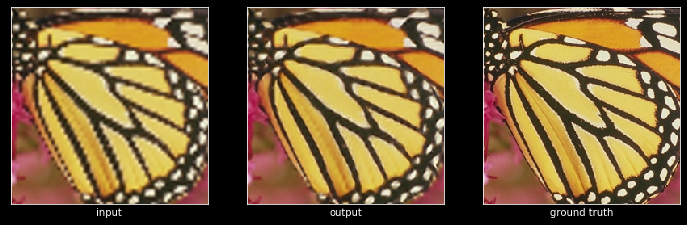

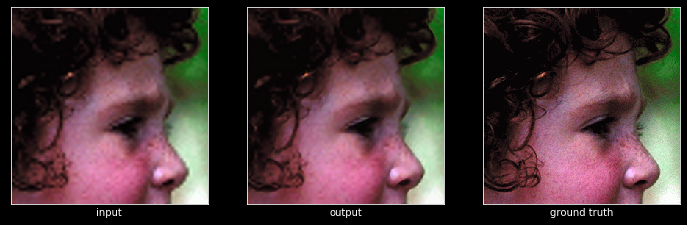

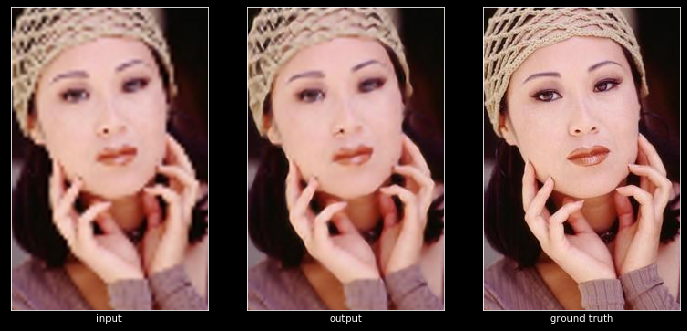

In [7]:
model_dir='models'
model_path = max(glob.iglob(os.path.join(model_dir, "*.h5")), key=os.path.getctime)
restored_model = tf.keras.models.load_model(model_path)
padding = get_padding(restored_model)
psnr = []

for filename in tf.io.matching_files("datasets/Test/Set5/*.bmp"):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image_string, channels=3)
    h, w, _ = image.get_shape()
    
    input = prepare_input_image(image, h, w, scale=4)
    gt = prepare_output_image(image, h, w, h - 2*padding, w - 2*padding)
    
    short_name = os.path.split(f"{filename}")[1]
    last_index = short_name.find("_")
    short_name = short_name[:last_index]
    
    # can't use plot_predictions on all images since they have different sizes
    psnr = psnr + plot_predictions(restored_model, [short_name], [input], [gt])
    
    
display_psnr(psnr)

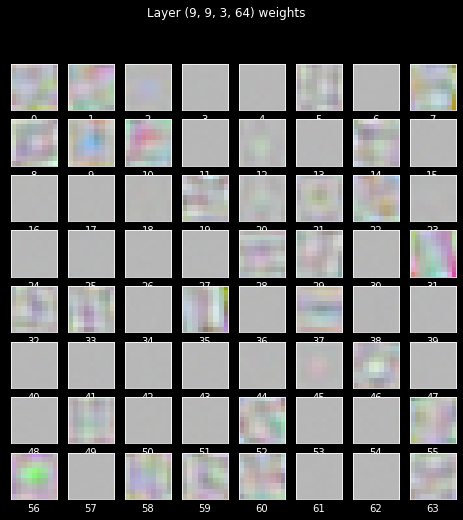

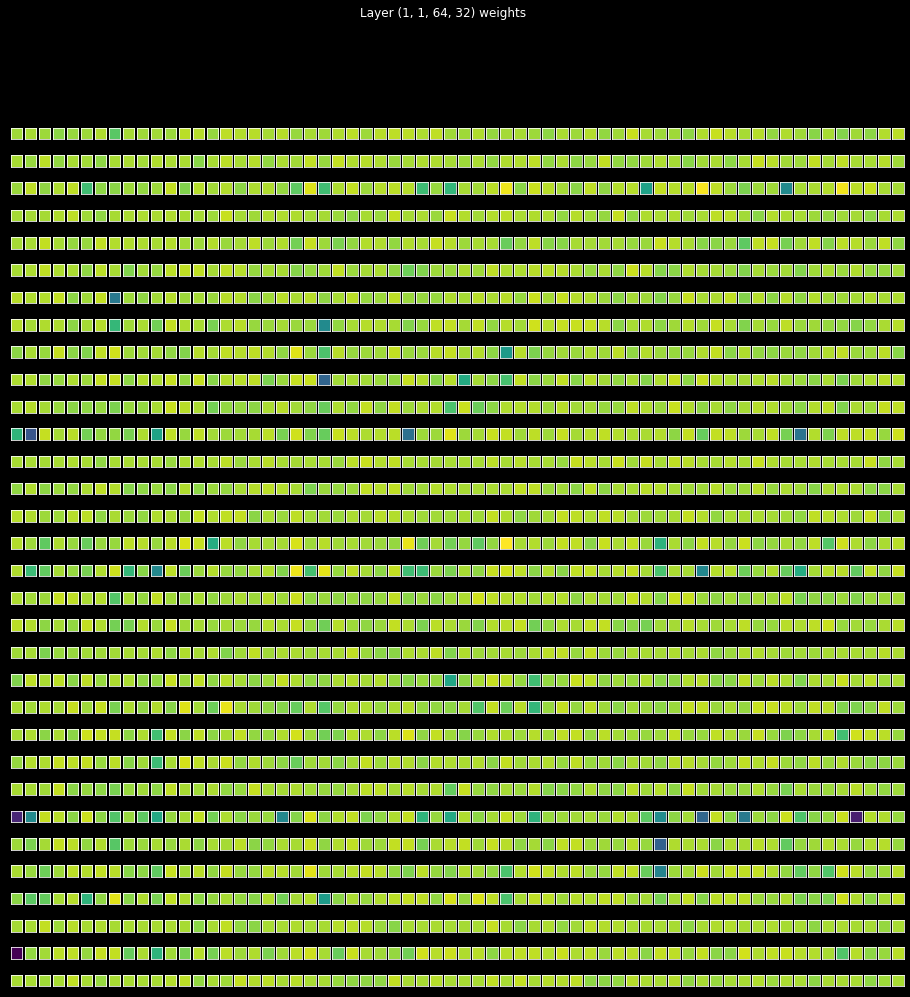

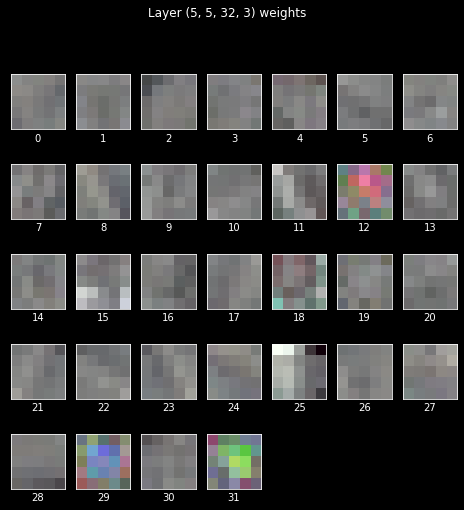

In [8]:
from srcnn.plot import plot_image
import matplotlib.pyplot as plt
import math
import matplotlib.colors as clr

plt.style.use(['dark_background'])

for layer in restored_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        filters, biases = layer.get_weights()
        h, w, c, n = filters.shape
        
        fmin, fmax = filters.min(), filters.max()
        filters = (filters - fmin) / (fmax - fmin)
        if (c == 3):
            fig = plt.figure(figsize=(8, 8))
            fig.suptitle(f'Layer {filters.shape} weights', color='w')
            gridsize = int(n ** 0.5)
            for i in range(n):
                plt.subplot(gridsize, int(math.ceil(n / gridsize)), i+1)
                plot_image(filters[:, :, :, i], label=str(i))
        elif (n == 3):
            fig = plt.figure(figsize=(8, 8))
            fig.suptitle(f'Layer {filters.shape} weights', color='w')
            gridsize = int(c ** 0.5)
            for i in range(c):
                plt.subplot(gridsize, int(math.ceil(c / gridsize)), i+1)
                plot_image(filters[:, :, i, :], label=str(i))
        else:
            fig = plt.figure(figsize=(16, 16))
            fig.suptitle(f'Layer {filters.shape} weights', color='w')
            for i in range(n):                
                for ci in range(c):
                    plt.subplot(n, c, i*c + ci + 1)
                    plot_image(filters[:, :, ci, i], norm=clr.Normalize(vmin=0,vmax=1))
        